In [49]:
# modules
import pandas as pd
import sys
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages


import ndx_ecog  # Even though we won't use this directly, we need to import it when reading our NWB files since we use the ECoG extension
from pynwb import NWBHDF5IO
from changlab_to_nwb.TDT_to_NWB import TDTtoNWB
from mne.io import RawArray
from mne import create_info, find_events, Epochs, concatenate_epochs

# paths
root_dir = '/Users/jdisanto/Documents/2022/changlab-rotation/ecog_barakeet'
plot_dir = '%s/vis' % (root_dir)
textgrid_dir = '%s/external/TextGrids' % (root_dir)


In [2]:
# helper script to get timing from the textgrids
def event_timing(word, amb_level, tg_dir, time_lock):
    from glob import glob

    # build fname"
    fname = glob('%s/*_%s_*%s*.TextGrid' % (textgrid_dir, word, int(amb_level)))[0]

    # load file
    tg = pd.read_csv(fname)

    # lock to moment
    if time_lock == 'POD':
        for ii in range(len(tg)):
            if 'POD' in str(tg.values[ii]):
                pod_timing = float(str(tg.values[ii+5]).split('= ')[1].split(' ')[0])

    elif time_lock == 'word_offset':
        for ii in range(len(tg)):
            if 'word' in str(tg.values[ii]):
                pod_timing = float(str(tg.values[ii+2]).split('= ')[1].split(' ')[0])

    return pod_timing

In [3]:
def rolling_window(array, window_size, freq):
    shape = (array.shape[0] - window_size + 1, window_size)
#     print(shape)
    strides = (array.strides[0],) + array.strides
#     print(strides)
    rolled = np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)
    return rolled[np.arange(0, shape[0], freq)]


In [10]:
subject = 'EC243'
block = '48'
'''
subject:    str, e.g. "EC228"
blocks:     list, e.g. ['35', '36']
data_type:  str, options: "LFP", "high_gamma"
time_lock:  str, options: "word_onset", "POD", "word_offset"
tmin:       float, seconds
tmax:       float, seconds
'''

# paths
data_dir = '%s/data-ecog' % (root_dir)

# loop through blocks to get epochs
epoch_list = list()

print('Analysing data for %s B%s..' % (subject, block))

# load log file
log = pd.read_csv('%s/%s_sequence_B%s.csv' % (logfile_dir, subject, block))

# clean log file to just get auditory trials
log = log.query("stim_number > 0")

# read nwb file
nwb_path = '%s/%s_B%s.nwb' % (data_dir, subject, block)
nwb_file_io = NWBHDF5IO(nwb_path, 'r')
nwb_file = nwb_file_io.read()

#         print(nwb_file.stimulus['speaker1'].data[0:100])

speaker_data = nwb_file.stimulus['speaker1'].data[0:int(13745118/2)]

data_len = speaker_data.shape[0]
figure(figsize=(16, 6), dpi=80)


speaker_rate = nwb_file.stimulus['speaker1'].rate
silence_thresh = 0.08
silence_len = int(0.5 * speaker_rate)


data_bool = speaker_data > silence_thresh
# print(sum(data_bool))
windows = rolling_window(data_bool, silence_len, 1)
# print(sum(windows[0]))
silent_windows = ~np.array(list(map(np.any, windows)))
# print(sum(silent_windows))
switches = silent_windows[:-1] > silent_windows[1:]
# print(sum(switches))
onset_idx = np.where(switches == True)[0]
onset_idx += silence_len #idx should be end of window
# print(silent_windows)
print(onset_idx)

Analysing data for EC243 B48..
[ 255911  348903  435853  539572  618606  698272  783400  906002  998169
 1072024 1161451 1266830 1360407 1452304 1556124 1660609 1742834 1827218
 1953587 2072440 2185173 2306869 2434113 2518322 2590190 2677093 2763391
 2846464 2911481 3026679 3123858 3210481 3294504 3386372 3474542 3568606
 3668662 3763553 3882799 3995476 4081368 4181820 4256579 4387354 4481658
 4563435 4630064 4718089 4797437 4883268 4965744 5080995 5184673 5265325
 5340066 5436189 5532715 5636858 5718946 5810602 5907632 6010680 6107484
 6242633 6348886 6452426 6574803 6716221 6824038]


<Figure size 1280x480 with 0 Axes>

stimuli/2_bountiful_bm_004.wav
stimuli/35_penecillin_pb_008.wav
stimuli/2_bountiful_bm_003.wav
stimuli/11_desolate_dn_003.wav
stimuli/11_desolate_dn_002.wav
stimuli/2_mountains_bm_003.wav
stimuli/2_bountiful_bm_006.wav
stimuli/11_desolate_dn_004.wav
stimuli/35_beneficial_pb_010.wav
stimuli/11_necessary_dn_006.wav
stimuli/35_penecillin_pb_010.wav
stimuli/11_desolate_dn_007.wav
stimuli/2_mountains_bm_002.wav
stimuli/2_mountains_bm_004.wav
stimuli/35_penecillin_pb_006.wav


TypeError: 'AxesSubplot' object is not subscriptable

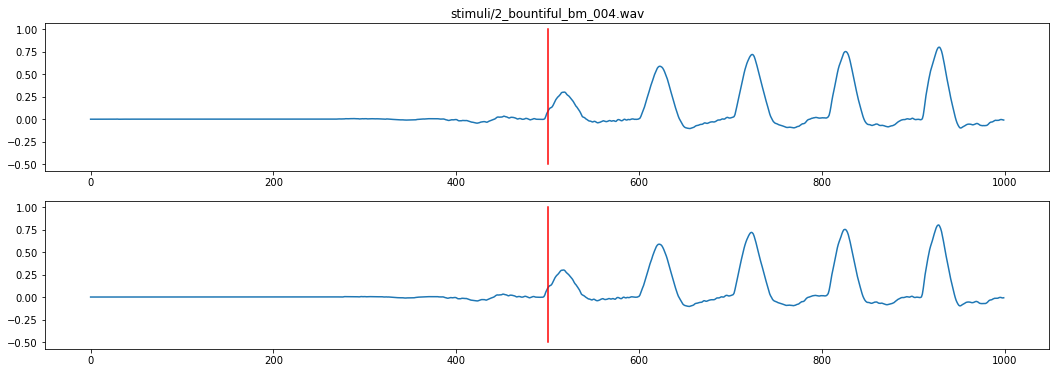

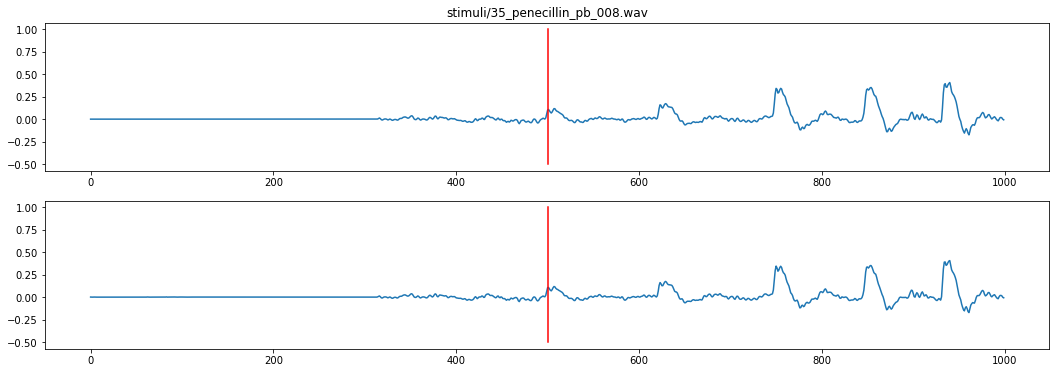

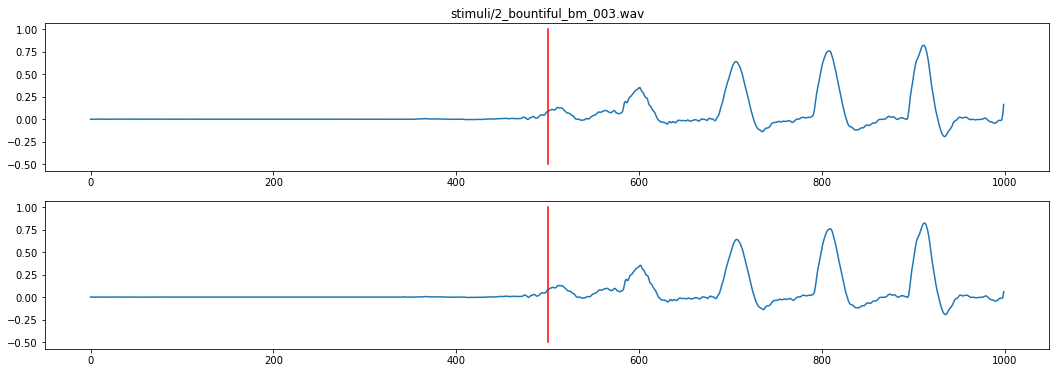

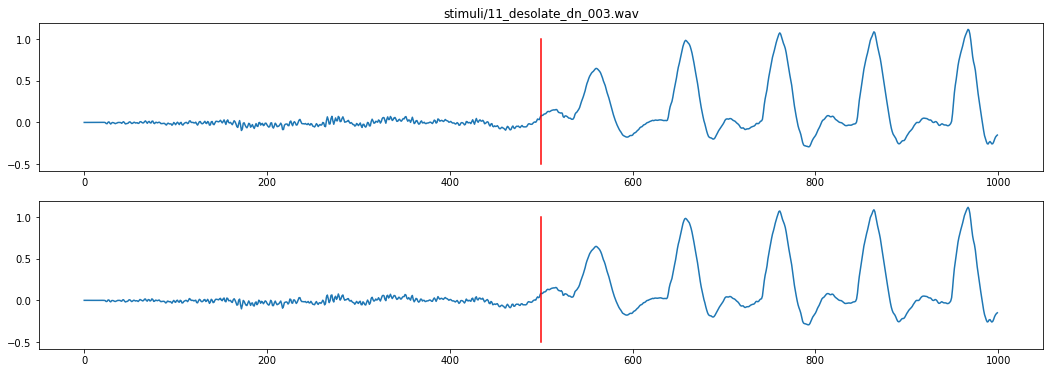

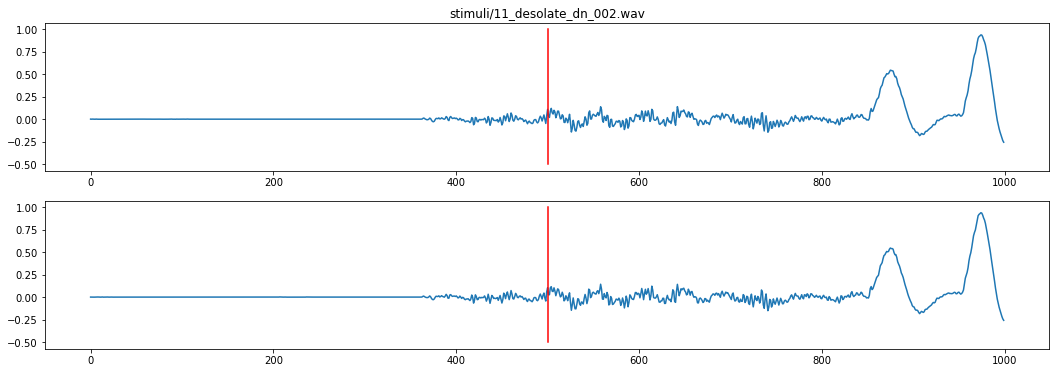

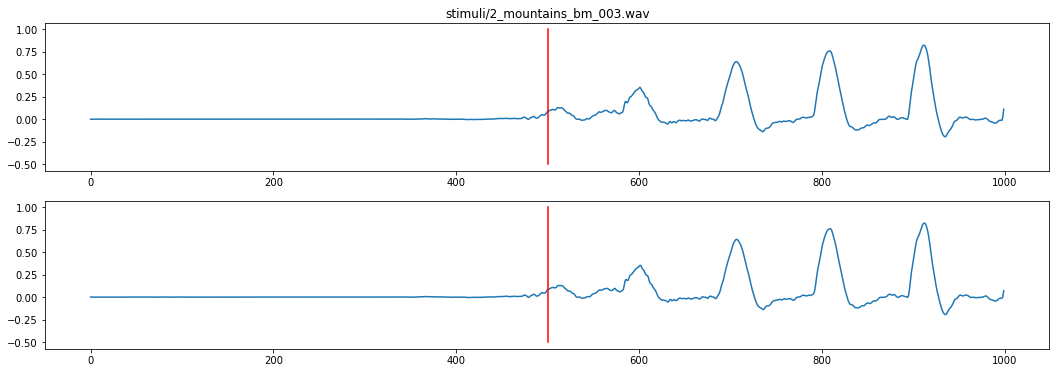

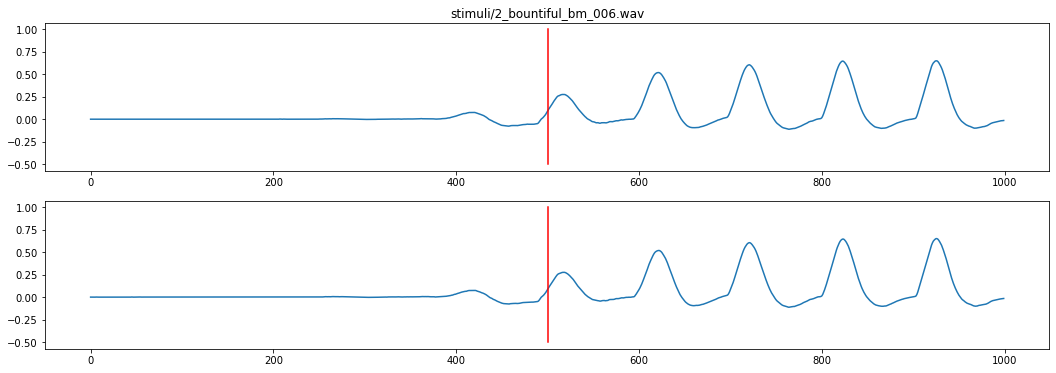

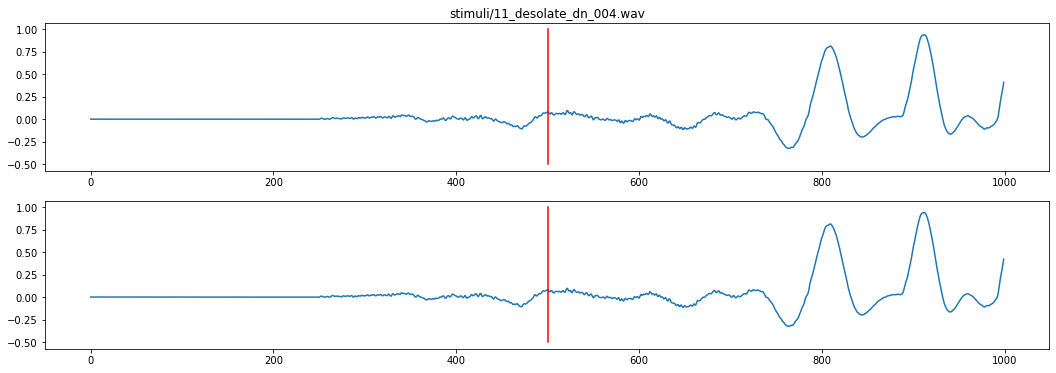

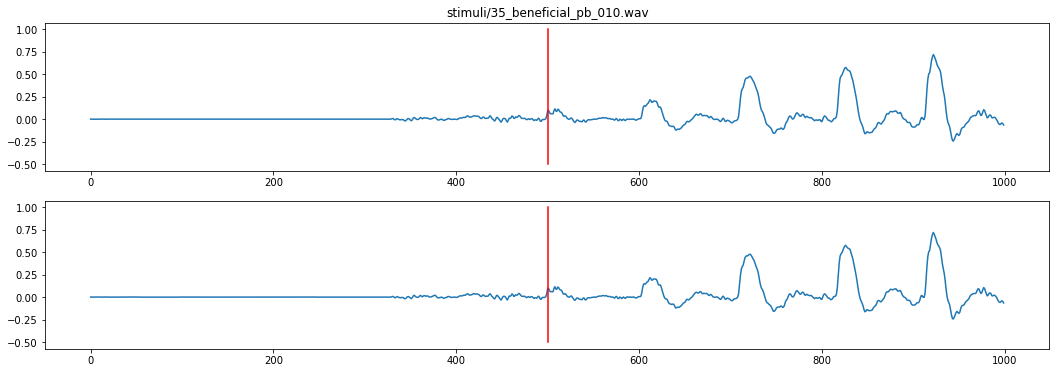

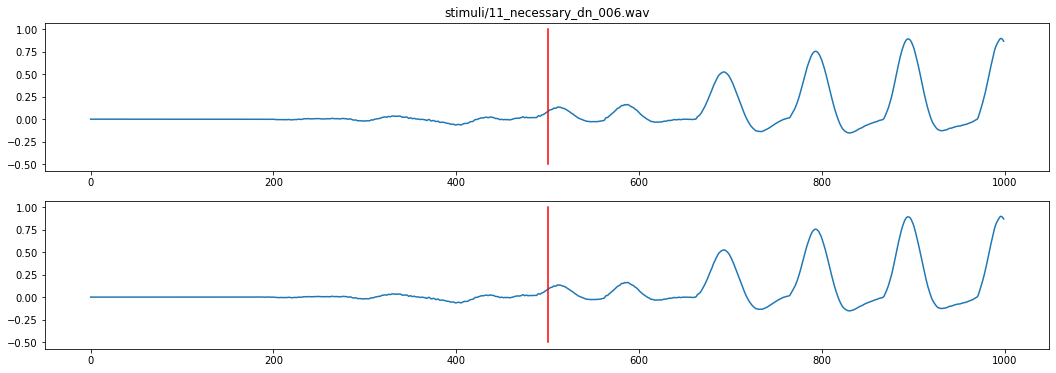

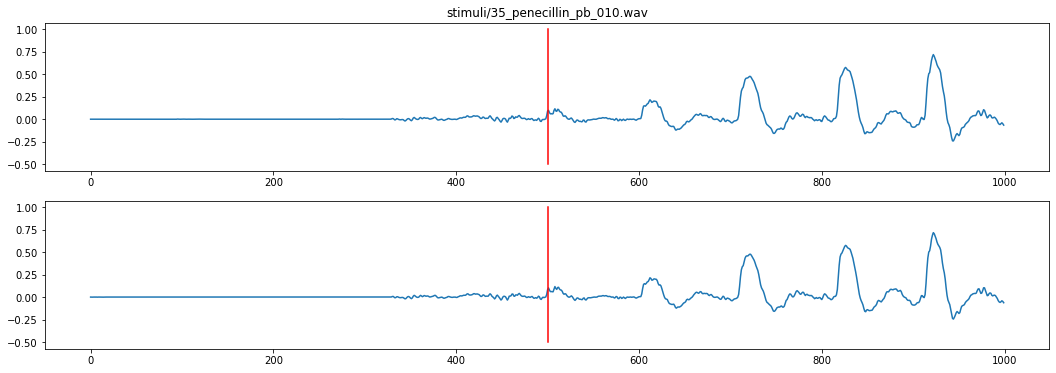

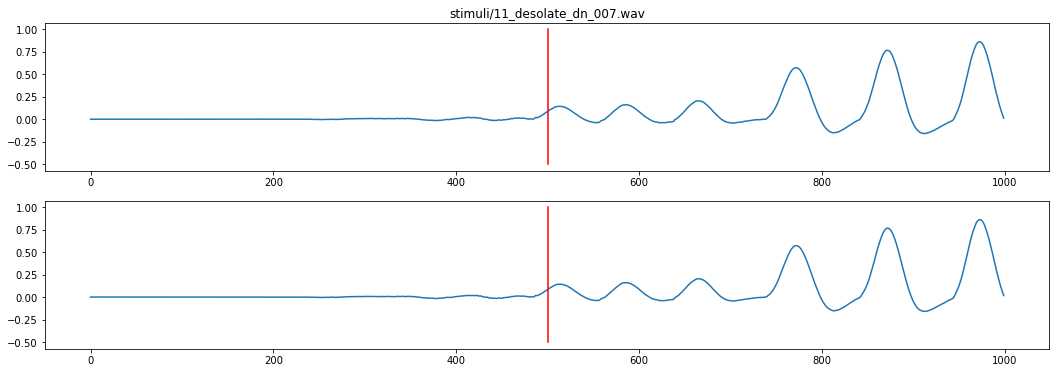

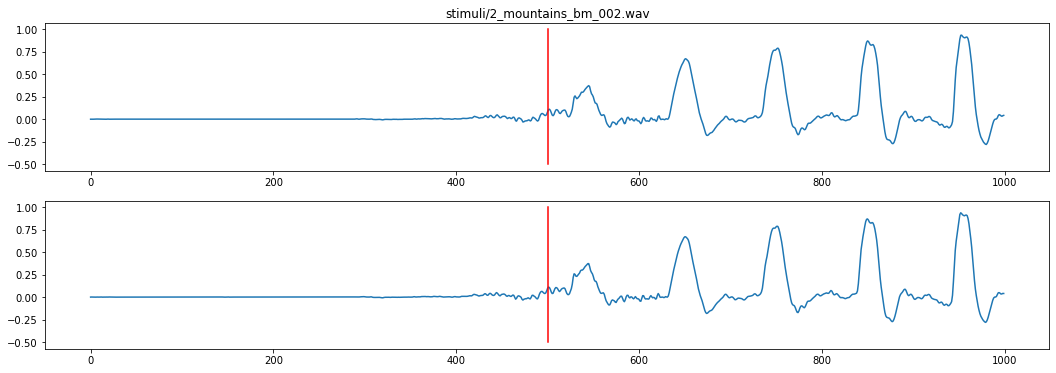

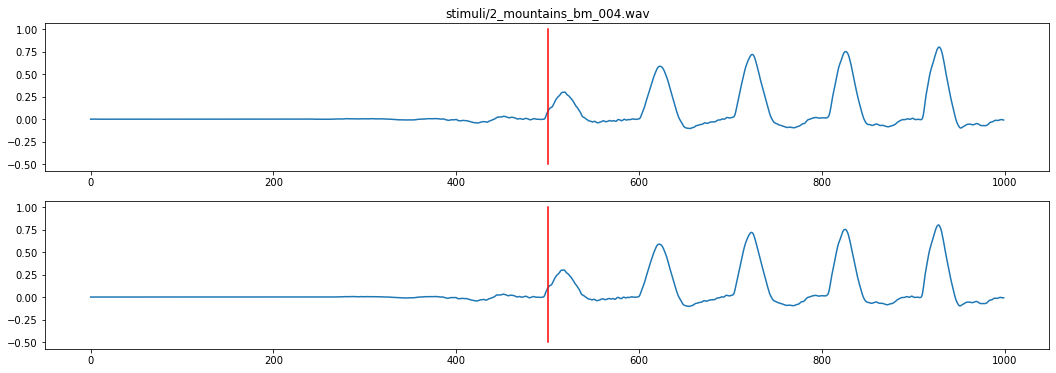

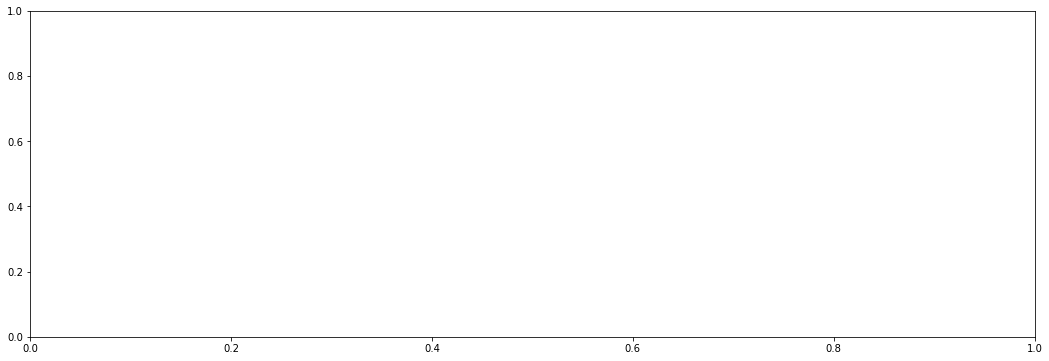

In [50]:
plts = PdfPages('test_wav_onsets.pdf')

# paths
logfile_dir = '%s/data/logfiles' % (root_dir)

# get file
file = '%s/EC243_sequence_B48.csv' % (logfile_dir)

# put into dataframe
df = pd.read_csv(file)
df = df[np.array([str(s) != 'nan' for s in df['stim_number']])]
df = df.reset_index()

df_sub = df[0:len(onset_idx)]
wavs_sub = np.array(df_sub['wav_file'])
wavs_sub_unique = df_sub['wav_file'].unique()


for i, wav in enumerate(wavs_sub_unique):
    print(wav)
    df_wav = df_sub.query('wav_file == @wav')

    fig, axs = plt.subplots(len(df_wav), 1, figsize=(18,6))
        
    trials = np.where(wavs_sub == wav)[0]
    for j, t in enumerate(trials):
        sample = onset_idx[t]
        window = 1000
        axs[j].plot(np.arange(window), speaker_data[sample-500 : sample+500])
        axs[j].plot([500,500], [-0.5,1], color='r')
        if j == 0: axs[j].set_title(wav)

    plts.savefig(fig)
    
plts.close()   
    

fig, axs = plt.subplots(1, 1, figsize=(18,6))

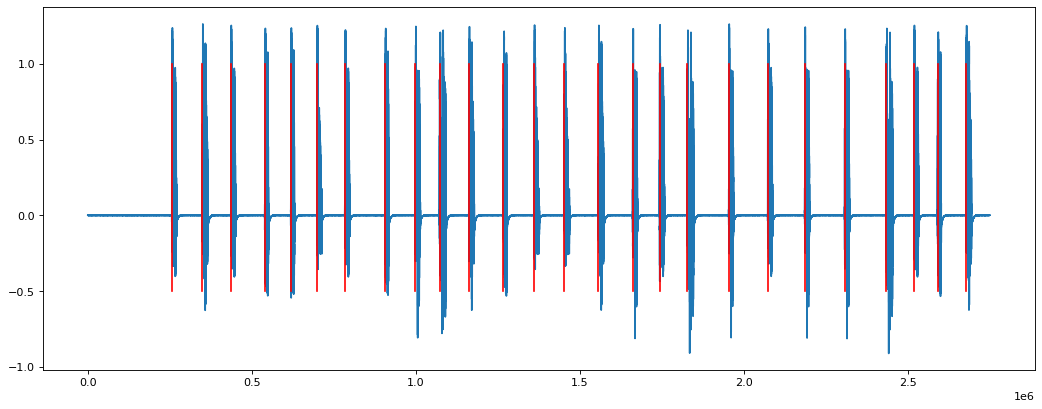

In [6]:
figure(figsize=(16, 6), dpi=80)
start = 255700
snip = speaker_data[start:257000]
x = np.arange(len(snip))
# print(idx[0][0])
# plt.plot([idx[0][0]-start+silence_len,idx[0][0]-start+silence_len], [-0.5,1], color='r')
plt.plot(np.arange(len(speaker_data)), speaker_data)
for i in idx:
    plt.plot([i+silence_len,i+silence_len], [-0.5,1], color='r')

In [ ]:
#3-5ms jitter is ok
#check consistency within word
#timelock ecog to onets - space & time distribution
#matrix trials x time x space
#start by averaging over first 200ms and over trials and plot magnitude in a grid of electrodes to find intereting electrodes
#16x16 electrode grid
#plot trials vs time




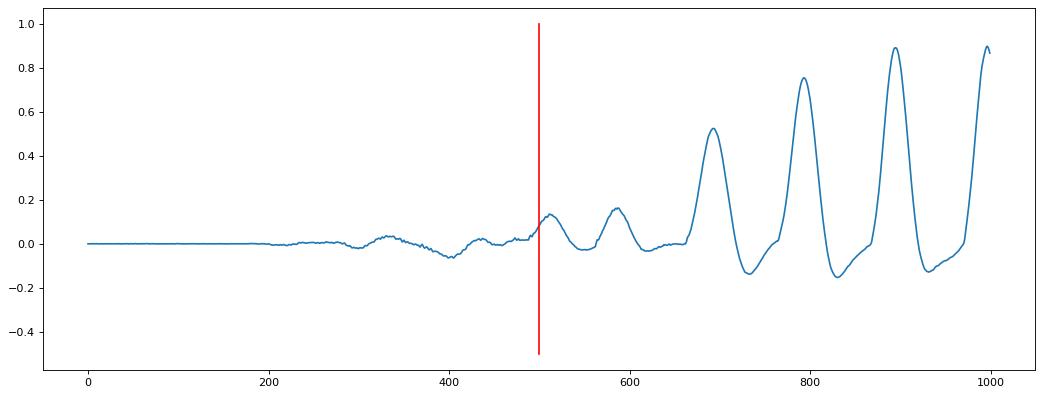

In [7]:
figure(figsize=(16, 6), dpi=80)
i = idx[0][9] + silence_len
window = 1000
plt.plot(np.arange(window), speaker_data[i-500 : i+500])
plt.plot([500,500], [-0.5,1], color='r')

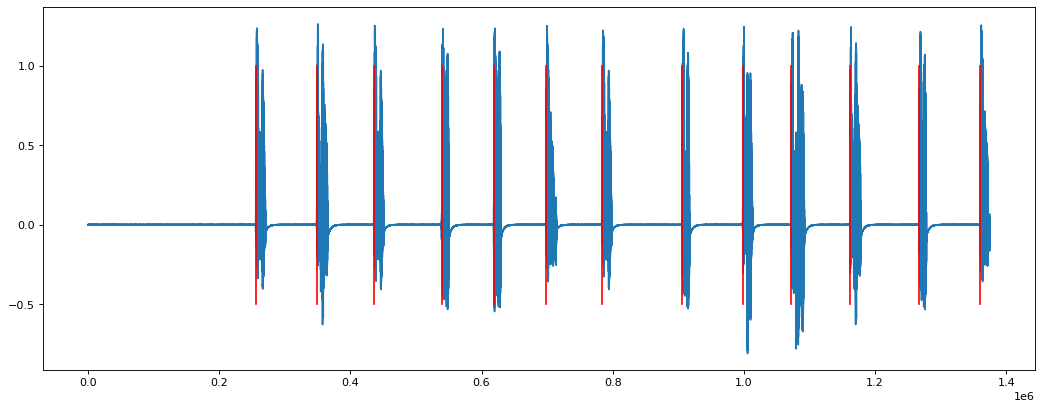

In [66]:
figure(figsize=(16, 6), dpi=80)
start = 255700
snip = speaker_data[start:257000]
x = np.arange(len(snip))
# print(idx[0][0])
# plt.plot([idx[0][0]-start+silence_len,idx[0][0]-start+silence_len], [-0.5,1], color='r')
plt.plot(np.arange(len(speaker_data)), speaker_data)
for i in idx:
    plt.plot([i+silence_len,i+silence_len], [-0.5,1], color='r')

In [15]:
print(idx)

(array([], dtype=int64),)


In [17]:
.5*24414

12207.0

In [48]:
a = np.array([-2, 1])
if all(x < 2 for x in np.abs(a)): print("ya")


In [ ]:
13745118

In [21]:
int(13745118/10)

1374511

In [61]:
True < True

False

In [106]:
a = [[True, True, True], [False, False, False], [True, True, True]]
b = [False, False, False]
c = ~np.array(list(map(np.any, a)))
print(c)
# print(np.any(b))
# print(np.any(a))

[False  True False]


In [95]:
a = np.array([-1, 2, 3])
b = a < 0
b

array([ True, False, False])

In [ ]:
#         print(len(speaker_data)
#         print(len(switches))

#         while window_max < data_len - 1:
#             #move window
#             if window_min % 100 == 0: print(window_min/data_len)
#             window_min += 1
#             window_max += 1
#             window = np.abs(speaker_data[window_min : window_max])
            
#             if silent:
#                 #if updated window crosses threshold, we found a word onset
#                 if np.abs(speaker_data[window_max]) >= silence_thresh:
#                     onsets.append(window_max)
#                     silent = False
#             else:
#                 #check if updated window is silent
#                 if all(x < silence_thresh for x in np.abs(window)):
#                     silent = True
                
#         print(len(onsets))
#         # load ecog
#         if data_type == 'raw':
#             ecog = nwb_file.acquisition['LFP']
#         elif data_type == 'high_gamma':  # this is for data that has been preprocessed through ecogVis
#             ecog = nwb_file.processing['ecephys']['high_gamma']
#         elif data_type == 'LFP':
#             ecog = nwb_file.processing['ecephys']['LFP']['preprocessed']
#         ecog_array = ecog.data.__array__()

        # get params of the data
#         sfreq = ecog.rate
# #         print('sfreq')
# #         print(sfreq)
#         ch_names = nwb_file.electrodes.label.data.__array__().tolist()
#         bads_bool = nwb_file.electrodes['bad'].data.__array__()

#         # set bads to zero
#         ecog_array[:, bads_bool] = 0

#         # zscore raw
#         ecog_array = zscore(ecog_array, axis=0)

#         # get time stamps (i think these aren't perfect -- check them)
#         event_samples = nwb_file.intervals['TimeIntervals_speaker']['start_time'].data.__array__()
#         plt.plot(event_samples)
#         event_times = event_samples * sfreq

#         # time lock options
#         if time_lock == 'POD' or time_lock == 'word_offset':
#             event_shifts = list()
#             for word, amb_level in log[['auditory_word', 'ambiguity']].values:
#                 shift = event_timing(word, amb_level, textgrid_dir, time_lock)
#                 event_shifts.append(int(shift*sfreq))
#             event_shifts = np.array(event_shifts)

#         else:
#             event_shifts = np.zeros(len(log))

#         # put this into an mne raw object
#         info = create_info(ch_names, sfreq, ch_types='ecog')
#         raw = RawArray(ecog_array.T, info)
#         raw.info['bads'] = np.array(raw.info['ch_names'])[bads_bool].tolist()

#         # make epochs
#         events = np.array([[0, 0, 0]]*len(event_times))
#         events[:, 0] = [int(t) for t in event_times] + event_shifts
#         epochs = Epochs(raw, events, tmin=tmin, tmax=tmax, metadata=log, preload=True,
#                         baseline=None)
#         epoch_list.append(epochs)
    
    # need to fix this -- bads need to be the same over blocks
#     ep_info = epoch_list[0].info
#     for eps in epoch_list:
#         eps.info = ep_info

#     # concatenate the epochs together
#     epochs = concatenate_epochs(epoch_list)

#     # add properties to metadata
    
#     # mirror slider so that the numbers match the acoustics not the lexical
#     acoustic_slider = list()
#     binned_responses = list()
#     flips = ['desolate', 'beneficial', 'mountains']
#     for word_end, slider_resp, block_type in epochs.metadata[['word_end',
#                                                               'slider.response',
#                                                               'block_type']].values:

#         # depends on the block type
#         if block_type == 1:
#             if word_end in flips:
#                 val = np.abs(slider_resp - 11)
#             else:
#                 val = slider_resp
#             acoustic_slider.append(val)

#         # depends on block type
#         if block_type == 2:
#             if word_end in flips:
#                 val = slider_resp
#             else:
#                 val = np.abs(slider_resp - 11)
#             acoustic_slider.append(val)

#         # a categorisation of behaviour into three classes
#         if val < 2:
#             binned_responses.append(1)
#         elif val >= 2 and val < 8:
#             binned_responses.append(2)
#         elif val >= 8:
#             binned_responses.append(3)

#     epochs.metadata['binned_responses'] = binned_responses
#     epochs.metadata['acoustic_slider'] = acoustic_slider

#     return epochs
